In [5]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
def get_frequencies(target_pubmed_id):
    all_mesh_terms = []
    with open('ourdat/citations_small200.TiAbMe') as citations_info:
        try:
            while(True):
                line = next(citations_info).strip()
                pubmed_id, _, num_cited = line.split("|")
                num_cited = int(num_cited)
                for _ in range(num_cited):
                    _ = next(citations_info) # original
                    _ = next(citations_info) # title
                    _ = next(citations_info) # abstract
                    mesh_terms = next(citations_info).strip().split('|')[2:]
                    if pubmed_id == target_pubmed_id:
                        terms = set()
                        for term in mesh_terms:
                            if term == '': continue
                            cleaned_up_term = term.split(',')[0].split('!')[0].split('*')[0]
                            terms.add(cleaned_up_term.lower())
                        all_mesh_terms += list(terms)

        except StopIteration:
            pass

    mesh_term_frequencies = Counter(all_mesh_terms)
    frequencies = list(mesh_term_frequencies.items())
    return frequencies

In [8]:
def get_mesh_terms(target_pubmed_id):
    with open('paperdat/SMALL200/S200.TiAbMe') as info_file:
        for line in info_file:
            record = line.split('|')
            if record[0] != target_pubmed_id: continue
            if record[1] != 'm': continue
            
            mesh_terms = record[2:]
            terms = set()
            for term in mesh_terms:
                term = term.strip()
                if term == '': continue
                cleaned_up_term = term.split(',')[0].split('!')[0].split('*')[0]
                terms.add(cleaned_up_term.lower())
            return list(terms)

In [9]:
def show_wordcloud(pubmed_id):
    plt.figure(figsize = (8,6))
    wordcloud = WordCloud().fit_words(get_frequencies(pubmed_id))
    plt.imshow(wordcloud, aspect='auto')
    plt.axis("off")
    print(get_mesh_terms(pubmed_id))

['receptors', 'ras proteins', 'arabidopsis proteins', 'mice', 'ras-grf1', 'neurons', 'signal transduction', 'enzyme activation', 'extracellular signal-regulated map kinases', 'animals', 'cells', 'stroke', 'sos1 protein', 'protein-serine-threonine kinases', 'ras guanine nucleotide exchange factors', 'cyclic amp response element-binding protein']


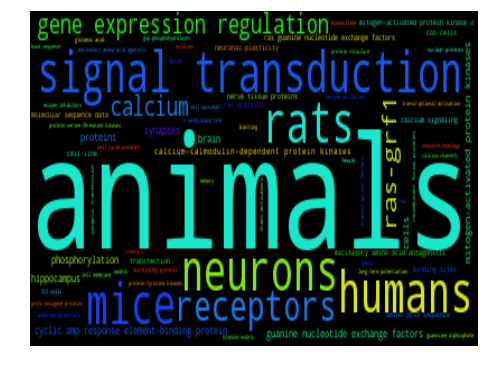

In [10]:
show_wordcloud('15029245')

['gene expression regulation', 'amino acid sequence', 'yeasts', 'sequence alignment', 'arabidopsis proteins', 'cell division', 'sequence analysis', 'plant roots', 'phylogeny', 'molecular sequence data', 'transcription factors', 'arabidopsis']


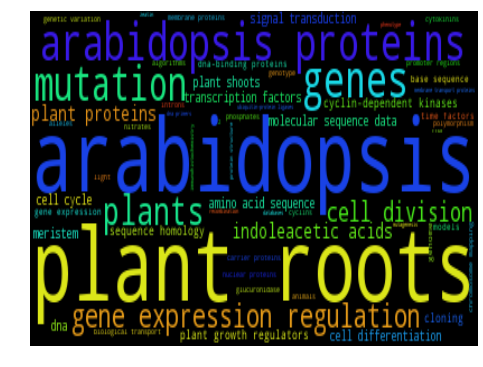

In [39]:
show_wordcloud('15031265')

['embryo', 'receptors', 'mice', 'protease inhibitors', 'fibrin', 'dipeptides', 'male', 'neovascularization', 'embryo loss', 'plasminogen activators', 'in situ hybridization', 'embryo implantation', 'placentation', 'pregnancy', 'matrix metalloproteinases', 'plasminogen', 'animals', 'female', 'placenta']


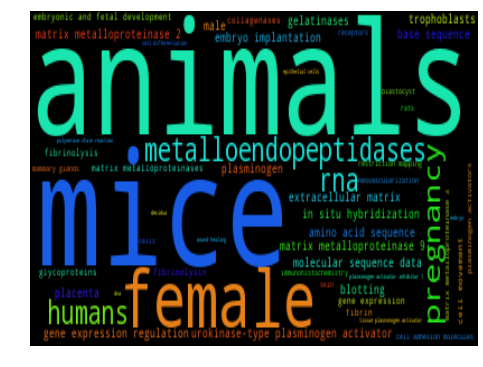

In [40]:
show_wordcloud('12900459')

In [22]:
def get_ranking(pubmed_id):
    frequencies = get_frequencies(pubmed_id)
    frequencies.sort(key=lambda x: -x[1])
    
    return [x for (x,y) in frequencies]

In [23]:
def get_actual_mesh_terms(pubmed_id):
    all_mesh_terms = []
    with open('paperdat/SMALL200/S200.TiAbMe') as article_info:
        for line in article_info:
            items = line.split('|')
            
            while '\n' in items:
                items.remove('\n')
            
            pmid = items[0]
            typ = items[1]
            
            if pmid == pubmed_id:
                if typ == 'm':
                    mesh_terms = items[2:]
                    terms = set()
                    for term in mesh_terms:
                        if term == '': continue
                        cleaned_up_term = term.split(',')[0].split('!')[0].split('*')[0]
                        terms.add(cleaned_up_term.lower())
                        
                    return list(terms)
                
    return None

In [81]:
def compare_terms(predicted, actual):
    actual_set = set(actual)
    return [1 if p in actual_set else 0 for p in predicted[:25]]

In [54]:
def get_metrics(pubmed_id):
    predicted = get_ranking(pubmed_id)
    actual = get_actual_mesh_terms(pubmed_id)
    common_terms = compare_terms(predicted, actual)

    return common_terms, len(actual)

In [72]:
def precision(metrics):
    total_num_terms = 0
    for terms, _ in metrics:
        total_num_terms += sum(terms)
        
    return total_num_terms / (len(metrics[0][0])*len(metrics))

In [73]:
def recall(metrics):
    total_num_terms = 0
    total_actual_len = 0
    for terms, actual_len in metrics:
        total_num_terms += sum(terms)
        total_actual_len += actual_len
        
    return total_num_terms / total_actual_len

In [74]:
def f_score(metrics):
    p = precision(metrics)
    r = recall(metrics)
    return (2*p*r) / (p+r)

In [78]:
def avg_precision(metrics):
    common_terms, actual_len = metrics
    
    total_rank_sum = 0
    for r, is_correct in enumerate(common_terms):
        rank_num = r+1
        correct_up_to_r = sum(common_terms[:rank_num])
        
        total_rank_sum += is_correct * (correct_up_to_r / rank_num)
        
    return total_rank_sum / actual_len

In [76]:
def mean_avg_precision(metrics):
    total_avg_precision = 0
    for metric in metrics:
        total_avg_precision += avg_precision(metric)
        
    return total_avg_precision / len(metrics)

0.3216
0.6063348416289592
0.42028227914270777
0.45866688079955126
43
0.4018262987012987
0.8839285714285714


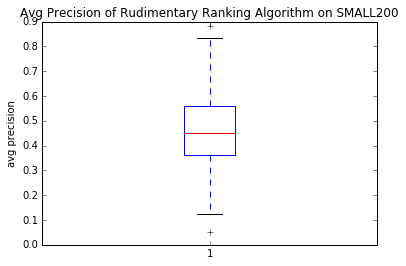

In [86]:
with open('paperdat/SMALL200/S200.pmids') as f:
    metrics = []
    for line in f:
        metrics.append(get_metrics(line.strip()))

print(precision(metrics))
print(recall(metrics))
print(f_score(metrics))
print(mean_avg_precision(metrics))

avg_precisions = [avg_precision(m) for m in metrics]
print(avg_precisions.index(max(avg_precisions)))
print(avg_precisions[3])
print(avg_precisions[43])

plt.boxplot(avg_precisions)
plt.ylabel('avg precision')
plt.title('Avg Precision of Rudimentary Ranking Algorithm on SMALL200')

['receptors', 'mice', 'cell line', 'animals', 'killer cells', 'microscopy', 'humans']


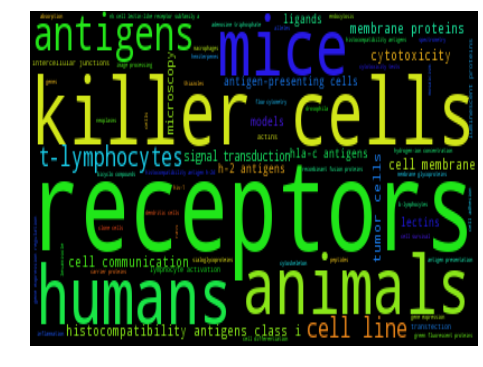

In [85]:
show_wordcloud('15550544')